# Introduction

This document is the data analysis to create an analytical model between position and cv coordinates in the image.

In [1]:
import re
import pandas as pd
from os import listdir
from os.path import isfile, join
import numpy as np
from matplotlib import pyplot as plt
import os

# Change the current working directory to import the files from the submodule
if os.getcwd().split("\\")[-1] != "control-system":
    os.chdir("control-system")

from src.computervision import load_img_from_file, ObjectDetection, MODEL_WEIGTS_DIR_DRACO # NOTE the IDE will not correctly interpret that this are in scope due to the change in current working directory

img_dir = "C:\\Users\\alvar\\University of Southampton\\GDP - Control System\\pictures"
iters = 1

def regex(input_comment: str) -> (float, float, float):
    result = re.search(r"d([0-9]+)h([0-9-]+)p([0-9]+)r?([0-9]*).jpg", input_comment)
    return result.group(1), result.group(2), result.group(3), result.group(4)


def post_process(cv: ObjectDetection, filename: str) -> (float, float, float, float):
    img = load_img_from_file(join(img_dir, filename))
    leaders = cv.process(img)

    if len(leaders) > 0:
        leader = leaders[0]

        return leader.confidence, leader.width_non_dimensional, leader.height_non_dimensional, leader.center_x_non_dimensional

    print(f"Failed to find leader in {filename}")
    return None, None, None, None

In [30]:
cv = ObjectDetection(MODEL_WEIGTS_DIR_DRACO)

# Get all file names of images
files = [f for f in listdir(img_dir) if isfile(join(img_dir, f))]

# Remove the file names that don't match the structure
condition = re.compile(r'd[0-9]+h[0-9-]+p[0-9]+r?[0-9]*.jpg')
img = [s for s in files if condition.match(s)]

# Load the filenames into Pandas dataframe
data = pd.DataFrame()

data["filename"] = img * iters

data["distance"], data["yaw"], data["pitch"], data["resolution"] = zip(*data["filename"].map(regex))

data["distance"] = data["distance"].replace("6", "5")

# Iterate over pandas dataframe to determine the values of pixels with respect to angles and distances
data["confidence"], data["width_nd"], data["height_nd"], data["center_x_nd"] = zip(*data["filename"].map(lambda x: post_process(cv, x)))

data.to_csv("output.csv")

# Data post processing
data["area"] = data["width_nd"] * data["height_nd"]

## Filter the post process data to get rid of the NaN values that cannot be post processed

In [31]:
complete_data = data[data["width_nd"].notnull()]

In [39]:
# Curve fitting and noise function

class linear_poly:
    m = 0
    c = 0

distance = linear_poly()
[distance.m, distance.c] = np.polyfit(1 / complete_data["distance"].astype(float).to_numpy(), complete_data["area"].to_numpy(), 1)

yaw = linear_poly()
[yaw.m, yaw.c] = np.polyfit(complete_data["yaw"].astype(float).to_numpy(), complete_data["center_x_nd"].to_numpy(), 1)

print(f"{distance.m=}, {distance.c=}, {yaw.m=}, {yaw.c=}")

distance.m=0.2321811593396554, distance.c=-0.011203148896388791, yaw.m=-0.025169415051060438, yaw.c=0.5363684179915779


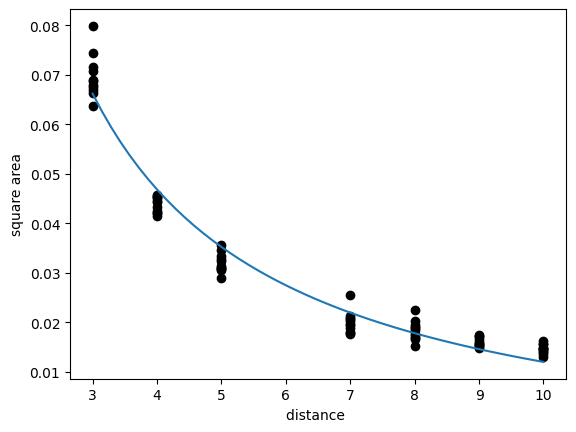

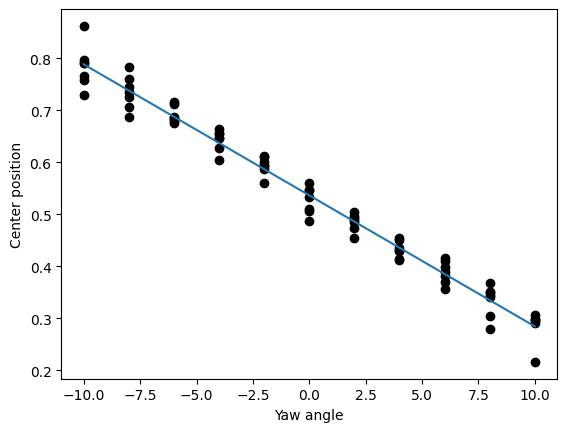

In [40]:
distance_placeholder = np.linspace(min(data["distance"].astype(float)), max(data["distance"].astype(float)))

plt.scatter(data["distance"].astype(float), data["area"], color="black")
plt.plot(distance_placeholder, distance.m * (1/distance_placeholder) + distance.c)
plt.xlabel("distance ")
plt.ylabel("square area")
plt.show()


yaw_placeholder = np.linspace(min(data["yaw"].astype(float)), max(data["yaw"].astype(float)))
plt.plot(yaw_placeholder, yaw.m * yaw_placeholder + yaw.c)
plt.scatter(data["yaw"].astype(float), data["center_x_nd"], color="black")
plt.xlabel("Yaw angle")
plt.ylabel("Center position")
plt.show()

# Investigating the relation with horizontal distance

In the plot above there is a possibility that the error encountered is due to the differences in distance. This is unlikely due to the nature of the experiment measuring the angle between the target and the camera but due to the simplicity to check this it is worth evaluating.

Below the data is translated such that 
$$s = d \times \tan(\text{yaw angle})$$
and plotted against the center offset.

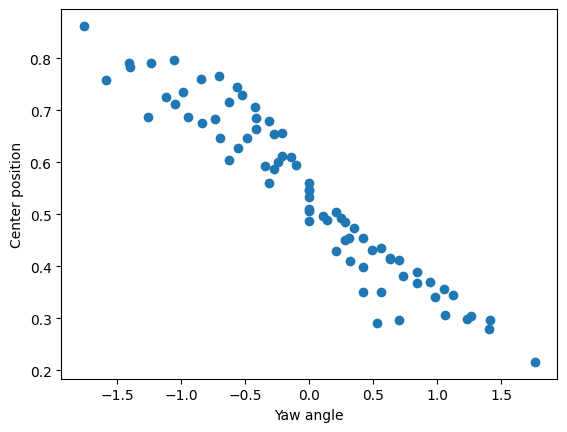

In [12]:
complete_data["s"] = complete_data["distance"].astype(float) * np.tan(np.radians(complete_data["yaw"].astype(float)))

plt.scatter(complete_data["s"], complete_data["center_x_nd"])
plt.xlabel("Yaw angle")
plt.ylabel("Center position")
plt.show()

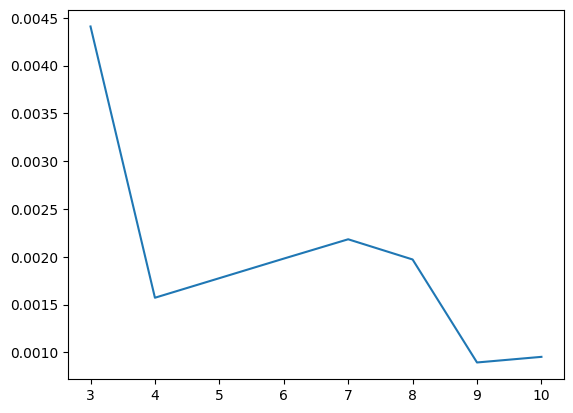

In [ ]:
# Determining the standard deviation
distances = complete_data["distance"].astype(float).unique()

distances.sort()

std = np.zeros(len(distances))

for inx, i in enumerate(distances):
    std[inx] = complete_data[i == complete_data["distance"].astype(float)]["area"].std()

plt.plot(distances, std)